<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese_ORL_ResNet/Siamese_ORL(ResNet)v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm
from sklearn.decomposition import PCA
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
 
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.cuda.is_available()

True

In [4]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
 
# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19

In [5]:
seed_init()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [8]:
class CustomDataset(Dataset):
 
    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform
        
        self.total_images = self._get_images(self.dirs, self.transform)
 
    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti
        
    def __len__(self):
        return self.dirs.__len__()
    
    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)
# ref : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [9]:
process = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4422, std=0.1931),
])
 
# dataset = list(att_dataset)
# torch.cat(dataset).mean() , torch.cat(dataset).std()
# #  (tensor(0.4417), tensor(0.1958))

In [10]:
att_dataset = CustomDataset(PATH, transform=process)

100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


In [ ]:
att_dataset[0][0].shape

torch.Size([1, 224, 224])

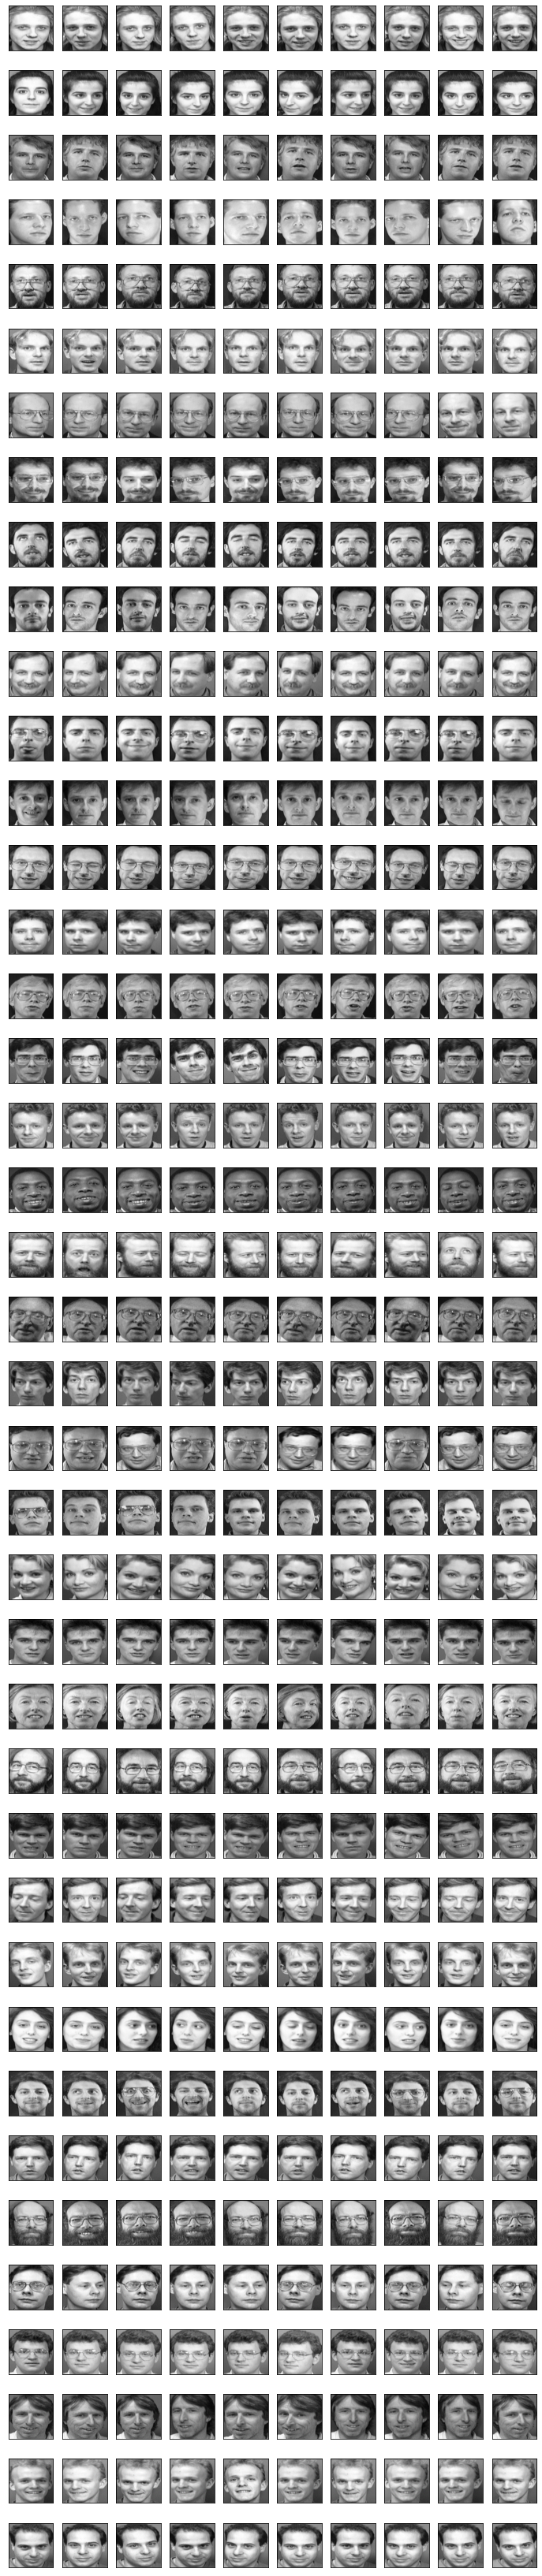

In [ ]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [11]:
dataset = list(att_dataset)
torch.cat(dataset).mean() , torch.cat(dataset).std()
#  (tensor(0.4417), tensor(0.1958))

(tensor(-7.0951e-05), tensor(0.9998))

In [12]:
def triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [13]:
def get_random_triplets(embeddings) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''
 
 
    triplets = []
    temp_list = list(range(len(embeddings)))
    for i, embedding in enumerate(embeddings):
        aclass = temp_list.pop(i)  ## Anchor class
 
        temp_list2 = list(range(len(embedding)))
        for j, anchor in enumerate(embedding):  ## for anchor in anchor class
            aidx = temp_list2.pop(0)
            if len(temp_list2)<1:
                break
            pidx = random.choice(temp_list2)
            positive = embedding[pidx]
 
            for nidx in temp_list:
                negative = random.choice(embeddings[nidx])
 
                # print(f"Anchor Class : {aclass}; anchor image : {j}{aidx}, positive image : {pidx}; negative class : {nidx}")
                triplets.append(torch.stack([anchor, positive, negative], dim=0))
 
            # temp_list2.insert(j,aidx)
            # print()
        temp_list.insert(i, aclass)
 
    return torch.stack(triplets, dim=0)

In [14]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1).pow(.5)

In [ ]:
triplets = get_random_triplets(train)

In [ ]:
triplets.shape

torch.Size([8436, 3, 1, 224, 224])

In [15]:
dataset = torch.stack(dataset)
dataset.shape

torch.Size([40, 10, 1, 224, 224])

In [16]:
train = dataset[0:38,:7,...]
train.shape

torch.Size([38, 7, 1, 224, 224])

In [17]:
test = dataset[0:38,7:,...]
test.shape

torch.Size([38, 3, 1, 224, 224])

In [18]:
def get_random_triplets_old(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''
 
 
#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"
 
    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)
 
        for anchor in embedding:
            positive = random.choice(embedding)
 
            for negatives in embeddings:
                negative = random.choice(negatives)
 
                triplets.append(torch.stack([anchor, positive, negative], dim=0))
 
        embeddings.insert(i, temp)
 
    return torch.stack(triplets, dim=0)

In [ ]:
t1 = torch.rand(38,7,1,224,224)
triplets = get_random_triplets_old(list(t1))

1 loop, best of 5: 26.8 s per loop


In [ ]:
t = torch.rand(3,5,1,224,224)
triplets = get_random_triplets(t)

Anchor Class : 0; anchor image : 00, positive image : 2; negative class : 1
Anchor Class : 0; anchor image : 00, positive image : 2; negative class : 2

Anchor Class : 0; anchor image : 11, positive image : 3; negative class : 1
Anchor Class : 0; anchor image : 11, positive image : 3; negative class : 2

Anchor Class : 0; anchor image : 22, positive image : 3; negative class : 1
Anchor Class : 0; anchor image : 22, positive image : 3; negative class : 2

Anchor Class : 0; anchor image : 33, positive image : 4; negative class : 1
Anchor Class : 0; anchor image : 33, positive image : 4; negative class : 2

Anchor Class : 1; anchor image : 00, positive image : 4; negative class : 0
Anchor Class : 1; anchor image : 00, positive image : 4; negative class : 2

Anchor Class : 1; anchor image : 11, positive image : 4; negative class : 0
Anchor Class : 1; anchor image : 11, positive image : 4; negative class : 2

Anchor Class : 1; anchor image : 22, positive image : 4; negative class : 0
Anchor

In [ ]:
triplets.shape, len(triplets[0])

(torch.Size([24, 3, 1, 224, 224]), 3)

In [19]:
class ResidualBlock(nn.Module):
    
    def __init__(self, n_in :int , n_out :int , stride :int = 1, use_1x1conv=False):
        super(ResidualBlock, self).__init__()
 
        self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n_out)
 
        if use_1x1conv:
            self.downsample = nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=stride, padding=0, bias=False)),
                ('bn', nn.BatchNorm2d(num_features=n_out))
            ]))
        else:
            self.downsample = None
 
 
    def forward(self, x):
        x_shortcut = x
 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
 
        x = self.conv2(x)
        x = self.bn2(x)
 
        if self.downsample:
            x_shortcut = self.downsample(x_shortcut)
 
        x = x + x_shortcut
        x = self.relu(x)
 
        return x
 
# ref : https://d2l.ai/chapter_convolutional-modern/resnet.html
# ref : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L144

In [20]:
class ResNet(nn.Module):
 
    def __init__(self, layers = [2,2,2,2]):
        # resnet18 : layers = [2, 2, 2, 2]
        # resnet34 : layers = [3, 4, 6, 3]
        super(ResNet, self).__init__()
 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
 
        self.layer1 = nn.Sequential(
            self._make_layer(in_channels = 64, out_channels = 64, num_residuals = layers[0])                                 
        )
                            
        self.layer2 = nn.Sequential(
            self._make_layer(in_channels = 64, out_channels = 128, num_residuals = layers[1], reduce_dim = True) 
         )
 
        self.layer3 = nn.Sequential(
            self._make_layer(in_channels = 128, out_channels = 256, num_residuals = layers[2], reduce_dim = True) 
        )
                            
        self.layer4 = nn.Sequential(
            self._make_layer(in_channels = 256, out_channels = 512, num_residuals = layers[3], reduce_dim = True) 
        )
            
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Sequential(
            nn.Linear(in_features=512*1, out_features=128),
            nn.ReLU(inplace=True)
        )
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
 
    def _make_layer(self, in_channels:int, out_channels:int, num_residuals: int, reduce_dim = False):
        block_layers = []
        for i in range(num_residuals):
            if i == 0 and reduce_dim:
                block_layers.append((f'block{i+1}', ResidualBlock(n_in = in_channels, n_out = out_channels, stride=2, use_1x1conv = True)))
            else:
                block_layers.append((f'block{i+1}', ResidualBlock(n_in = out_channels, n_out = out_channels)))
 
        return OrderedDict( block_layers )
    
    # ref : https://d2l.ai/chapter_convolutional-modern/resnet.html
 
 
    def semi_forward(self, x):
 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = torch.flatten(input=x, start_dim=1) # ref : https://pytorch.org/docs/stable/generated/torch.flatten.html
        x = self.fc(x)
        return x
 
    def forward(self,triplet):
        # anc = self.semi_forward(triplet[:,0,...])
        # pos = self.semi_forward(triplet[:,1,...])
        # neg = self.semi_forward(triplet[:,2,...])
        
        batch_size = triplet.shape[0]
        # triplet = triplet.view(triplet.shape[0]*triplet.shape[1], triplet.shape[2], triplet.shape[3],triplet.shape[4])
        triplet = triplet.view(triplet.shape[0]*triplet.shape[1], *triplet.shape[2:])
        out = self.semi_forward(triplet)
        out = out.view(batch_size,3, *out.shape[1:])
        return torch.unbind(out,dim=1)
 
# ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [ ]:
resnet18 = ResNet()
resnet18.eval()
t1 = torch.rand(10,1,224,224)
t2 = torch.rand(10,1,224,224)
t3 = torch.rand(10,1,224,224)
print('rand', t1.shape)
t = resnet18.conv1(t1)
print('conv1', t.shape)
t = resnet18.maxpool(t)
print('maxpool', t.shape)
t = resnet18.layer1(t)
print('layer1', t.shape)
t = resnet18.layer2(t)
print('layer2', t.shape)
t = resnet18.layer3(t)
print('layer3', t.shape)
t = resnet18.layer4(t)
print('layer4', t.shape)
t = resnet18.avgpool(t)
print('avgpool', t.shape)
t = torch.flatten(t,1)
print('flatten', t.shape)
t = resnet18.fc(t)
print('fc', t.shape)

t = resnet18.semi_forward(t1)
print('semi', t.shape)

ts = torch.stack([t1,t2,t3],dim=1)
print('rand', ts.shape)
t_ = resnet18(ts)
print('resnet18', len(t_))
for a in t_:
     print(a.shape)

rand torch.Size([10, 1, 224, 224])
conv1 torch.Size([10, 64, 112, 112])
maxpool torch.Size([10, 64, 56, 56])
layer1 torch.Size([10, 64, 56, 56])
layer2 torch.Size([10, 128, 28, 28])
layer3 torch.Size([10, 256, 14, 14])
layer4 torch.Size([10, 512, 7, 7])
avgpool torch.Size([10, 512, 1, 1])
flatten torch.Size([10, 512])
fc torch.Size([10, 128])
semi torch.Size([10, 128])
rand torch.Size([10, 3, 1, 224, 224])
resnet18 3
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])


In [ ]:
# (torch.unbind(ts,dim=1)[0] == t1).sum()
(t_[0] == t).sum()

tensor(1280)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
count_parameters(resnet18)

11235904

In [24]:
def Train(model, batch, loss_fn, optimizer, cost):
    model.train()
 
    apn = model(batch.cuda())
 
    optimizer.zero_grad()
    loss = loss_fn(*apn)
    cost.append(loss.item())
    loss.backward()
    optimizer.step()
 
    return cost[-1]

In [25]:
def Evaluate(model, batch):
    model.eval()
    def dist(enc1,enc2):
        return (enc1 - enc2).pow(2).sum(-1) #.pow(.5)
 
    with torch.no_grad():
        sample = torch.cat([model.semi_forward(imgs[0].unsqueeze(0).cuda()).cpu() for imgs in batch])
        
        total_enc = [model.semi_forward(img.cuda()).cpu() for img in batch]
        
        pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(len(total_enc))]
        # acc = sum([(pred[i] == i).sum() for i in range(len(total_enc))])
        del total_enc
    # return (acc.item() / (len(batch) * 10) )
    return torch.stack(pred)

In [22]:
resnet18 = ResNet(layers=[2,2,2,2])
# resnet26 = ResNet(layers=[2,4,3,3])

In [ ]:
torch.set_grad_enabled(True)
resnet18.train(True)
# resnet26.train(True)

In [27]:
learning_rate = 0.0002
optimizer18 = optim.Adam(resnet18.parameters(), lr = learning_rate)
# optimizer26 = optim.Adam(resnet26.parameters(), lr = learning_rate)
torch_triplet_loss = nn.TripletMarginLoss()
if torch.cuda.is_available():
    resnet18 = resnet18.cuda()
    # resnet26 = resnet26.cuda()

In [28]:
# cost = [float('inf')]
cost18 = [float('inf')]
epoch_cost = []
# cost26 = [float('inf')] 
train_acc = [0]
test_acc = [0]
epochs = 10
for epoch in range(epochs):
 
    triplets = get_random_triplets(train)
    loader = DataLoader(triplets, batch_size=128, shuffle=True)
    epoch_loss = 0
    for i,batch in enumerate(loader):
 
        loss18 = Train(resnet18, batch, triplet_loss, optimizer18, cost18)
        epoch_loss += loss18
        # loss26 = Train(resnet26, batch, triplet_loss, optimizer26, cost26)
        
        # pred = Evaluate(resnet18, train)
        # acc1 = ( (pred == torch.arange(len(pred)).reshape(-1,1)).sum() / (len(pred)*10) ).item()
        # train_acc.append(acc1)
 
        # pred = Evaluate(resnet18, test)
        # acc2 = ( (pred == torch.arange(len(pred)).reshape(-1,1)).sum() / (len(pred)*10) ).item()
        # test_acc.append(acc2)
 
        if (i+1)%20==0 :
            # print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87]', 'Cost : {:.2f}, Train Acc: {:.2f}, Test Acc: {:.2f}'.format(loss, acc1, acc2))
            print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/77]', 'Cost : {:.2f}'.format(loss18))
            # print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/87]', 'Cost18 : {:.2f} Cost26 : {:.2f}'.format(loss18,loss26))
    epoch_cost.append(epoch_loss)

Epoch:[1/10], Step:[20/77] Cost : 0.06
Epoch:[1/10], Step:[40/77] Cost : 0.01
Epoch:[1/10], Step:[60/77] Cost : 0.01
Epoch:[2/10], Step:[20/77] Cost : 0.00
Epoch:[2/10], Step:[40/77] Cost : 0.09
Epoch:[2/10], Step:[60/77] Cost : 0.03
Epoch:[3/10], Step:[20/77] Cost : 0.01
Epoch:[3/10], Step:[40/77] Cost : 0.09
Epoch:[3/10], Step:[60/77] Cost : 0.00
Epoch:[4/10], Step:[20/77] Cost : 0.00
Epoch:[4/10], Step:[40/77] Cost : 0.00
Epoch:[4/10], Step:[60/77] Cost : 0.00
Epoch:[5/10], Step:[20/77] Cost : 0.01
Epoch:[5/10], Step:[40/77] Cost : 0.00
Epoch:[5/10], Step:[60/77] Cost : 0.00
Epoch:[6/10], Step:[20/77] Cost : 0.01
Epoch:[6/10], Step:[40/77] Cost : 0.00
Epoch:[6/10], Step:[60/77] Cost : 0.02
Epoch:[7/10], Step:[20/77] Cost : 0.00
Epoch:[7/10], Step:[40/77] Cost : 0.00
Epoch:[7/10], Step:[60/77] Cost : 0.00
Epoch:[8/10], Step:[20/77] Cost : 0.00
Epoch:[8/10], Step:[40/77] Cost : 0.00
Epoch:[8/10], Step:[60/77] Cost : 0.00
Epoch:[9/10], Step:[20/77] Cost : 0.02
Epoch:[9/10], Step:[40/77

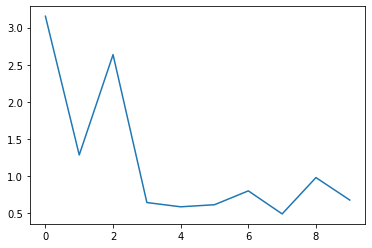

In [29]:
plt.plot(np.arange(len(epoch_cost)), epoch_cost, label='Epoch Losses')

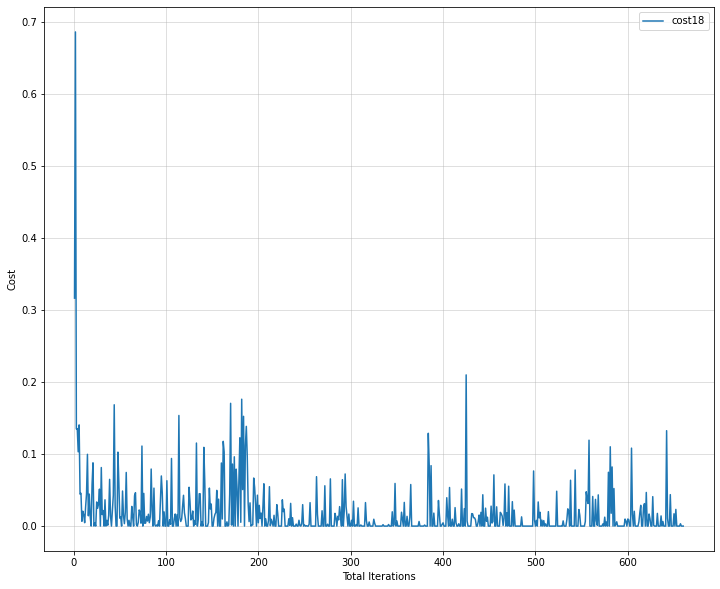

In [30]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
# plt.plot(np.arange(len(cost)), cost, label='cost')
plt.plot(np.arange(len(cost18)), cost18, label='cost18')
# plt.plot(np.arange(len(cost26)), cost26, label='cost26')
# plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
# plt.plot(np.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid(alpha=0.5)
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 38classes(resnet18)')
plt.show()

In [ ]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Accuracy')
plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(np.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid(alpha=0.5)
plt.legend()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 30classes(resnet)')
plt.show()

In [ ]:
torch.set_grad_enabled(False)
resnet18.train(False)
# resnet26.train(False)

In [36]:
total_enc = torch.stack([resnet18.semi_forward(img.cuda()).cpu() for img in tqdm(dataset)])
total_enc.shape

100%|██████████| 40/40 [00:00<00:00, 41.87it/s]


torch.Size([40, 10, 128])

In [43]:
train_enc = total_enc[0:38,:7,...]
train_enc.shape

torch.Size([38, 7, 128])

In [38]:
test_enc = total_enc[0:38,7:,...]
test_enc.shape

torch.Size([38, 3, 128])

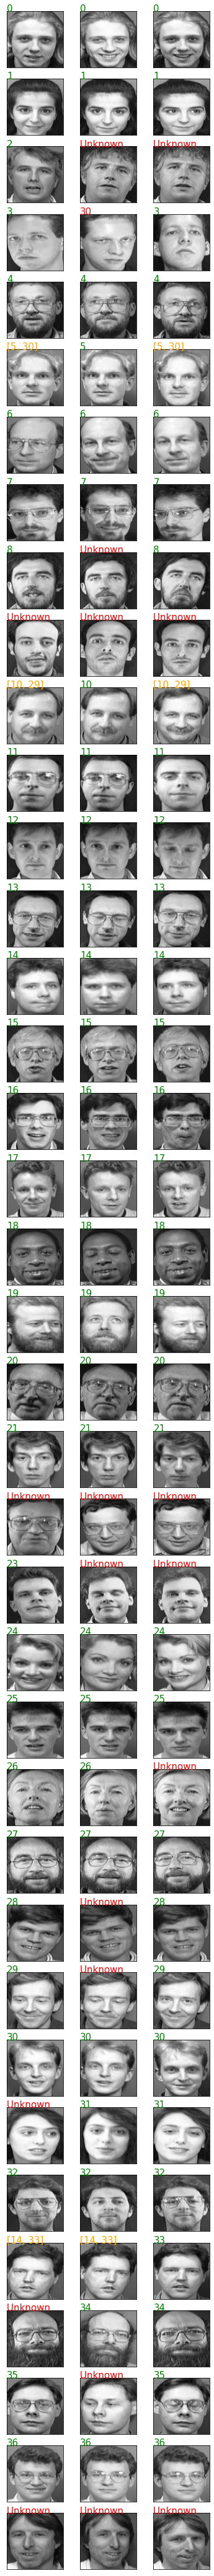

In [47]:
# ## Showing test dataset
# grid = torchvision.utils.make_grid(test.reshape(38*3,1,224,224), nrow=3, pad=100)
# plt.figure(figsize=(30,120))
# plt.imshow(np.transpose(grid, (1,2,0)))
threshold = 6
pred_matrix = []
shape = test_enc.shape
_,axxr = plt.subplots(shape[0],shape[1], figsize=(shape[1]*2,shape[0]*2))
 
for i in range(shape[0]):
 
    pred_class = []
    for j in range(shape[1]):
        axxr[i][j].imshow(test[i][j].squeeze(), cmap='gray')
        
        mean_dists = torch.mean(dist(train_enc,test_enc[i][j]) , dim=1)
        pred_idx = (mean_dists < threshold).nonzero()
        if len(pred_idx) > 1:
            axxr[i][j].text(0.5,2,f'{[idx.item() for idx in pred_idx]}', color='orange', fontsize=15)
            pred_class.append(-2)
        elif len(pred_idx) < 1:
            axxr[i][j].text(0.5,2,"Unknown ", color='red', fontsize=15)
            pred_class.append(-1)
        else:
            if pred_idx.item() == i:
                axxr[i][j].text(0.5,2,f'{pred_idx.item()}', color='green', fontsize=15)
                pred_class.append(pred_idx.item())
            else:
                axxr[i][j].text(0.5,2,f'{pred_idx.item()}', color='red', fontsize=15)
                pred_class.append(-1)
            
    pred_matrix.append(pred_class)
 
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Prediction on dataset[:38,7:,...]2.png', dpi=200)
plt.show()

In [ ]:
# ## Showing test dataset
# grid = torchvision.utils.make_grid(test.reshape(38*3,1,224,224), nrow=3, pad=100)
# plt.figure(figsize=(30,120))
# plt.imshow(np.transpose(grid, (1,2,0)))
threshold = 6
pred_matrix = []
shape = test_enc.shape
_,axxr = plt.subplots(shape[0],shape[1], figsize=(shape[1]*2,shape[0]*2))

for i in range(shape[0]):

    pred_class = []
    for j in range(shape[1]):
        axxr[i][j].imshow(test[i][j].squeeze(), cmap='gray')
        
        mean_dists = torch.mean(dist(train_enc,test_enc[i][j]) , dim=1)
        pred_idx = (mean_dists < threshold).nonzero()
        if len(pred_idx) > 1:
            axxr[i][j].text(0.5,2,f'{[idx.item() for idx in pred_idx]}', color='orange', fontsize=15)
            pred_class.append(-2)
        elif len(pred_idx) < 1:
            axxr[i][j].text(0.5,2,"Unknown ", color='red', fontsize=15)
            pred_class.append(-1)
        else:
            axxr[i][j].text(0.5,2,f'{pred_idx.item()}', color='green', fontsize=15)
            pred_class.append(pred_idx.item())
            
    pred_matrix.append(pred_class)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Prediction on dataset[:38,7:,...].png'/, dpi=200)
plt.show()

In [39]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)#.pow(.5)

In [ ]:
len(pred_idx)

1

Predicted Class :  tensor([[1]])


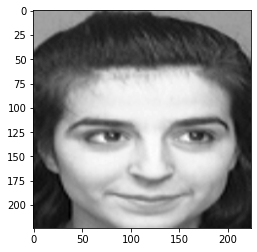

In [50]:
### show image
Class = 1
idx = 2
plt.imshow(test[Class][idx].squeeze(), cmap='gray')
mean_dists = torch.mean(dist(train_enc,test_enc[Class][idx]) , dim=1)
pred_idx = (mean_dists < 6).nonzero()
if len(pred_idx) > 1:
    print(f'Confused between :',*pred_idx)
elif len(pred_idx) < 1:
    print("Unknown Person")
else:
    print("Predicted Class : ", pred_idx)

In [ ]:
mean_dists

In [ ]:
(train_enc  - test_enc[0][0]).shape

torch.Size([38, 7, 128])

In [ ]:
dist(train_enc[37],total_enc[38][7])#.mean()

tensor([ 96.6048, 106.6639,  99.8019, 117.6391, 100.3575,  98.5482, 105.3826])

In [ ]:
pred_idx = (torch.mean(dist(train_enc,test_enc[7][0]) , dim=1) < 15).nonzero()#.item()

In [ ]:
[idx.item() for idx in pred_idx]

[7, 24, 30, 32]

In [40]:
pca = PCA(n_components=2)
x = train_enc.detach()
principalComponents = [pca.fit_transform(i) for i in x]

In [41]:
len(principalComponents), principalComponents[2].shape

(38, (7, 2))

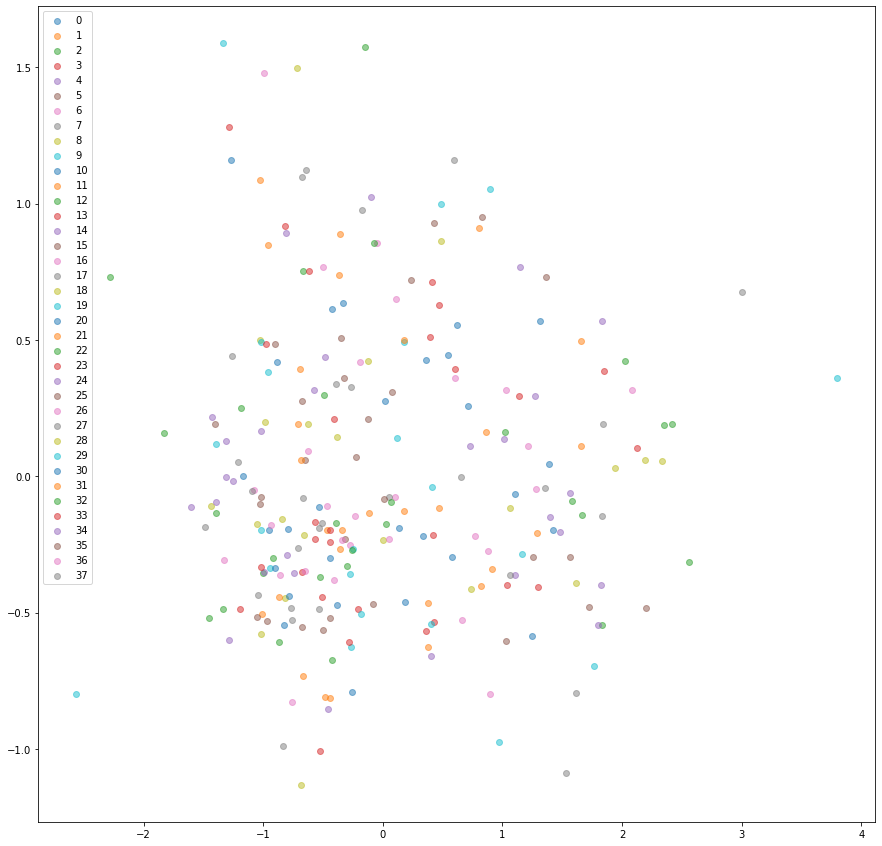

In [45]:
plot_embeddings(principalComponents, list(range(38)))

In [44]:
def plot_embeddings(principalComponents, targets):
    plt.figure(figsize=(15,15))
    for i,pc in enumerate(principalComponents) :
        plt.scatter(pc[:,0], pc[:,1], alpha=0.5, label=f'{targets[i]}')
    plt.legend()
    plt.show()

In [ ]:
pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
print(*pred, sep='\n')

In [ ]:
sum([(pred[i] == i).sum() for i in range(len(pred))]) / (len(pred) * 10) 

tensor(0.8700)

In [48]:
test_pred = Evaluate(resnet18, test)
test_acc = ( (test_pred == torch.arange(len(test_pred)).reshape(-1,1)).sum() / (test.shape[0]*test.shape[1]) ).item()
 
train_pred = Evaluate(resnet18, train)
train_acc = ( (train_pred == torch.arange(len(train_pred)).reshape(-1,1)).sum() / (train.shape[0]*train.shape[1]) ).item()
 
total_pred = Evaluate(resnet18, dataset)
total_acc = ( (total_pred == torch.arange(len(total_pred)).reshape(-1,1)).sum() / (dataset.shape[0]*dataset.shape[1]) ).item()
 
# test_pred = Evaluate(resnet26, test)
# test_acc = ( (test_pred == torch.arange(len(test_pred)).reshape(-1,1)).sum() / (len(test_pred)*10) ).item()
 
# train_pred = Evaluate(resnet26, train)
# train_acc = ( (train_pred == torch.arange(len(train_pred)).reshape(-1,1)).sum() / (len(train_pred)*10) ).item()
 
# total_pred = Evaluate(resnet26, dataset)
# total_acc = ( (total_pred == torch.arange(len(total_pred)).reshape(-1,1)).sum() / (len(total_pred)*10) ).item()

In [34]:
print('Train Acc: {:.2f}\nTest Acc: {:.2f}\nTotal Acc: {:.2f}'.format(train_acc, test_acc, total_acc))

Train Acc: 0.94
Test Acc: 0.89
Total Acc: 0.91


In [49]:
acc = []
pred = test_pred
for i in range(len(pred)):
    corr = (pred[i] == i).sum()
    print(f'(Claas {i})', corr.item(), 'out of 10')
    acc.append(corr.item())
 
print('Accuracy = ', sum(acc) / (len(pred)*len(pred[0])))
 
 
#@markdown Train Accuracy =82.0 %   
 
#@markdown Test Accuracy =  87.0 %  
 
#@markdown Total Accuracy =  88.0 %

(Claas 0) 3 out of 10
(Claas 1) 3 out of 10
(Claas 2) 3 out of 10
(Claas 3) 1 out of 10
(Claas 4) 3 out of 10
(Claas 5) 2 out of 10
(Claas 6) 3 out of 10
(Claas 7) 3 out of 10
(Claas 8) 3 out of 10
(Claas 9) 3 out of 10
(Claas 10) 3 out of 10
(Claas 11) 3 out of 10
(Claas 12) 3 out of 10
(Claas 13) 3 out of 10
(Claas 14) 2 out of 10
(Claas 15) 3 out of 10
(Claas 16) 3 out of 10
(Claas 17) 3 out of 10
(Claas 18) 3 out of 10
(Claas 19) 3 out of 10
(Claas 20) 3 out of 10
(Claas 21) 3 out of 10
(Claas 22) 2 out of 10
(Claas 23) 1 out of 10
(Claas 24) 2 out of 10
(Claas 25) 3 out of 10
(Claas 26) 3 out of 10
(Claas 27) 3 out of 10
(Claas 28) 2 out of 10
(Claas 29) 3 out of 10
(Claas 30) 3 out of 10
(Claas 31) 3 out of 10
(Claas 32) 3 out of 10
(Claas 33) 3 out of 10
(Claas 34) 2 out of 10
(Claas 35) 2 out of 10
(Claas 36) 3 out of 10
(Claas 37) 2 out of 10
Accuracy =  0.8947368421052632


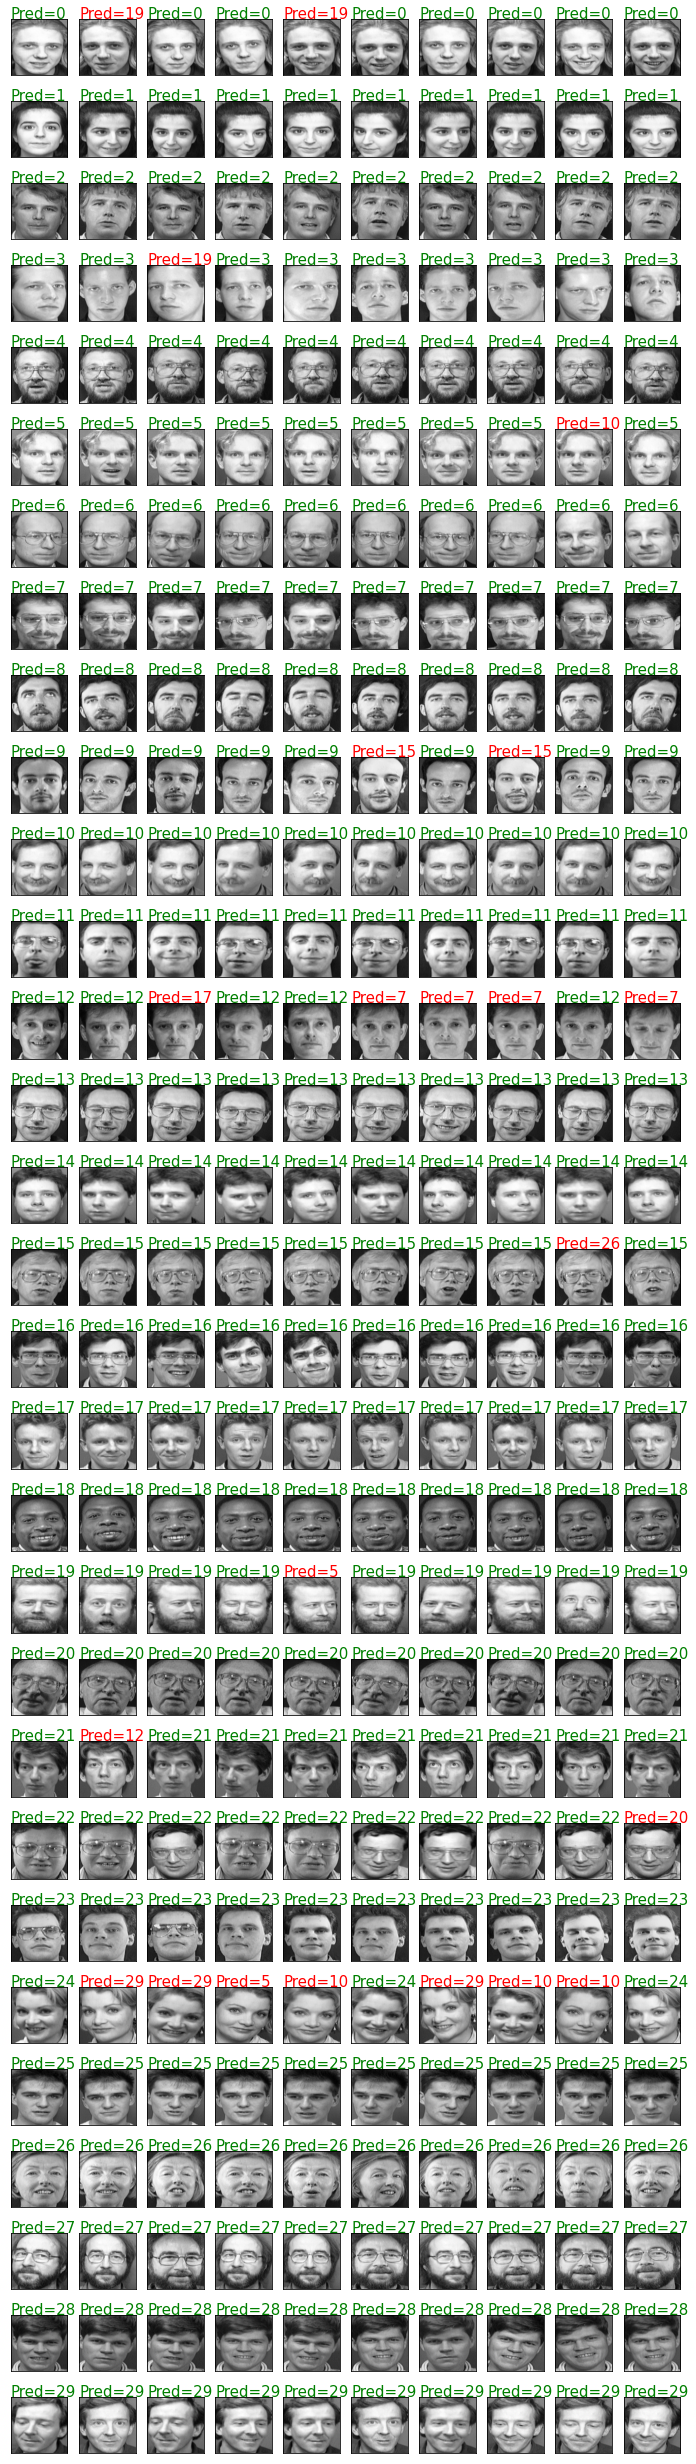

In [ ]:
_,axxr = plt.subplots(len(train_pred),10, figsize=(12,len(train_pred)*1.5))
for i in range(len(train_pred)):
    for j in range(10):
        axxr[i][j].imshow(train[i][j].squeeze(), cmap='gray')
        if train_pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={train_pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes(resnet).png', dpi=200)
plt.show()

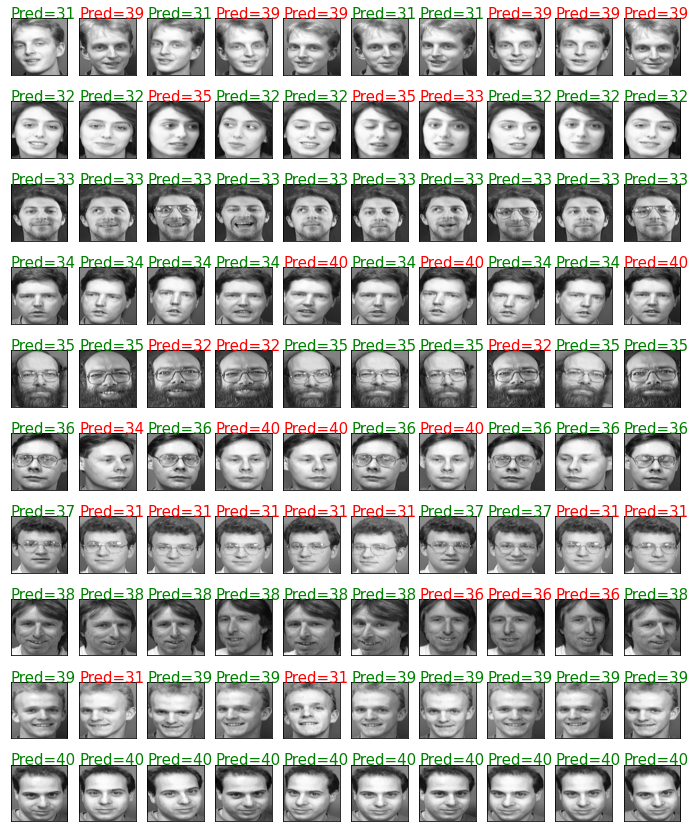

In [ ]:
_,axxr = plt.subplots(len(test_pred),10, figsize=(12,len(test_pred)*1.5))
for i in range(len(test_pred)):
    for j in range(10):
        axxr[i][j].imshow(test[i][j].squeeze(), cmap='gray')
        if test_pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i+31}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={test_pred[i][j].item() + 31}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes(resnet).png', dpi=200)
plt.show()

In [31]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese-orl(resnet)5'

In [32]:
torch.save(resnet18.state_dict(), PATH)

In [ ]:
# resnet18.load_state_dict(torch.load(PATH,  map_location=torch.device('cpu')))
resnet18.load_state_dict(torch.load(PATH))
resnet18.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [ ]:
tensor = torch.stack( [torch.stack([torch.arange(1,11), torch.arange(11,21), torch.arange(21,31)]) , torch.stack([torch.arange(31,41), torch.arange(41,51), torch.arange(51,61)])] )
tensor

tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
         [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
         [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]],

        [[31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
         [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
         [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]]])

In [ ]:
help(torch.cat)

Help on built-in function cat:

cat(...)
    cat(tensors, dim=0, *, out=None) -> Tensor
    
    Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
    All tensors must either have the same shape (except in the concatenating
    dimension) or be empty.
    
    :func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
    and :func:`torch.chunk`.
    
    :func:`torch.cat` can be best understood via examples.
    
    Args:
        tensors (sequence of Tensors): any python sequence of tensors of the same type.
            Non-empty tensors provided must have the same shape, except in the
            cat dimension.
        dim (int, optional): the dimension over which the tensors are concatenated
    
    Keyword args:
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> x = torch.randn(2, 3)
        >>> x
        tensor([[ 0.6580, -1.0969, -0.4614],
                [-0.1034, -0.5790,  0.1497]])
        >>

In [ ]:
out = tensor.view(tensor.shape[0]*tensor.shape[1], *tensor.shape[2:])
out

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
        [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]])

In [ ]:
apn = out.view(2,3, out.shape[1])
apn

tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
         [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
         [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]],

        [[31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
         [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
         [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]]])

In [ ]:
apn[:,0,...]

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]])

In [ ]:
torch.unbind(apn,dim=1)

(tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
         [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]]),
 tensor([[11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
         [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]]),
 tensor([[21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
         [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]]))

In [ ]:
type(torch.split(apn,3))

tuple